In [2]:
using MeshCatMechanisms
using MeshCat
using LinearAlgebra
using RigidBodyDynamics
using Plots
using GeometryTypes
using CoordinateTransformations
using TrajectoryOptimization

In [3]:
T = Float64

# options
max_con_viol = 1.0e-8
verbose=false
opts_ilqr = iLQRSolverOptions{T}(verbose=verbose,iterations=300,live_plotting=:off)

opts_al = AugmentedLagrangianSolverOptions{T}(verbose=verbose,opts_uncon=opts_ilqr,
    iterations=20,cost_tolerance=1.0e-6,cost_tolerance_intermediate=1.0e-5,
    constraint_tolerance=max_con_viol,penalty_scaling=50.,penalty_initial=0.01)

opts_pn = ProjectedNewtonSolverOptions{T}(verbose=verbose,feasibility_tolerance=max_con_viol,
    solve_type=:feasible)

opts_altro = ALTROSolverOptions{T}(verbose=verbose,opts_al=opts_al,opts_pn=opts_pn,
    projected_newton=false,projected_newton_tolerance=1.0e-5);

DIRCOLSolverOptions{Float64}
  nlp: Symbol SNOPT7
  opts: Dict{Symbol,Any}
  verbose: Bool false
  feasibility_tolerance: Float64 -1.0


In [5]:
prob_altro = copy(Problems.kuka_obstacles);

In [6]:
# ALTRO w/o Newton
p1, s1 = solve(prob_altro, opts_altro)
max_violation_direct(p1)

┌ Info: Augmented Lagrangian solve...
└ @ TrajectoryOptimization /home/taylor/.julia/dev/TrajectoryOptimization/src/altro.jl:24


3.186747012107194e-9

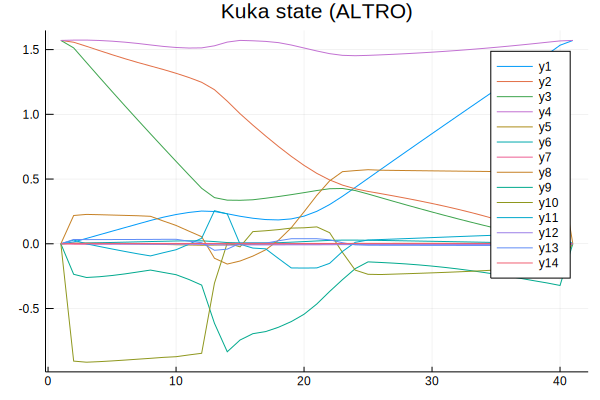

In [7]:
plot(p1.X,title="Kuka state (ALTRO)")

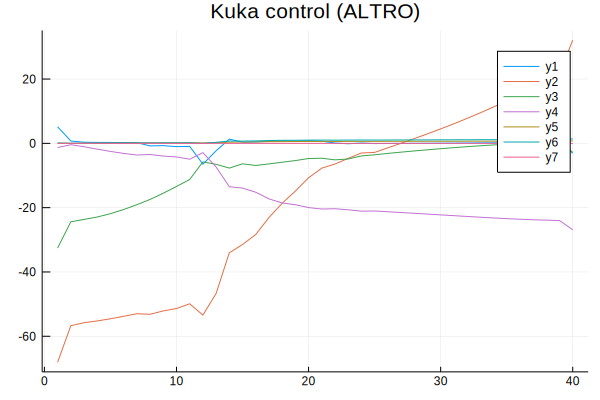

In [8]:
plot(p1.U,title="Kuka control (ALTRO)")

In [16]:
# Visualization
kuka = parse_urdf(Dynamics.urdf_kuka,remove_fixed_tree_joints=false)
kuka_visuals = URDFVisuals(Dynamics.urdf_kuka)

function plot_sphere(vis::MechanismVisualizer,frame::CartesianFrame3D,center,radius,mat,name="")
    geom = HyperSphere(Point3f0(center), convert(Float32,radius))
    setelement!(vis,frame,geom,mat,name)
end

function plot_cylinder(vis::MechanismVisualizer,frame::CartesianFrame3D,c1,c2,radius,mat,name="")
    geom = Cylinder(Point3f0(c1),Point3f0(c2),convert(Float32,radius))
    setelement!(vis,frame,geom,mat,name)
end

function addcircles!(vis,circles,robot)
    world = root_frame(robot)
    for (i,circle) in enumerate(circles)
        p = Point3D(world,collect(circle[1:3]))
        setelement!(vis,p,circle[4],"obs$i")
    end
end

function addcylinders!(vis,cylinders,robot,height=1.5,clr=MeshPhongMaterial(color=RGBA(0, 0, 1, 0.5)))
    world = root_frame(robot)
    for (i,cyl) in enumerate(cylinders)
        plot_cylinder(vis,world,[cyl[1],cyl[2],0],[cyl[1],cyl[2],height],cyl[3],clr,"cyl_$i")
    end
end

function visualize_kuka_obstacles(vis,prob,circles_kuka,cylinders_kuka)
    N = length(prob.X)
#     vis = Visualizer()
#     IJuliaCell(vis);    
    mvis = MechanismVisualizer(kuka, kuka_visuals, vis[:base])
    addcircles!(mvis,circles_kuka,kuka)
    addcylinders!(mvis,cylinders_kuka,kuka)
    q = [prob.X[k][1:convert(Int,prob.model.n/2)] for k = 1:N]
    t = range(0,stop=prob.tf,length=N)
    setanimation!(mvis,t,q)
end

visualize_kuka_obstacles (generic function with 2 methods)

In [17]:
vis = Visualizer()
IJuliaCell(vis)
visualize_kuka_obstacles(vis,p1,Problems.kuka_obstacles_objects[1],Problems.kuka_obstacles_objects[2])